## Ridehail Fare Model Creation
For: 
- taxi
- TNC

Currently have ABM3 model data and survey responses. Need to model trips for unchosen alternatives. Initial idea is a linear model w/ a bias (base fare) & per-mile cost. 

Auto skim distances are used to determine length of trip. 

For TNCs, to try to account for flexible fares, this notebook will explore the per-mile cost is interacted w/ the TOD category. TOD is determined using ABM3 categories (EA, AM, MD, PM, EV).

### Set-Up

In [75]:
# modules
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy
import sklearn
import pandas as pd

In [76]:
# import data
data_path = '../../data/processed/survey_data_matched_geographies_TAZ.csv'
taxi_tnc_fare_outliers_path = '../../data/processed/taxi_tnc_fare_outliers.csv'
# export data
output_path = '../../data/processed/fhv_fares.csv'

In [77]:
# take non-synthetic departing pax
survey_data = pd.read_csv(data_path).query('weight_departing_only > 0')

C:\Users\mwe\AppData\Local\Temp\ipykernel_20248\3239972433.py:2: DtypeWarning: Columns (21,26,27,28,29,30,31,32,33,34,35,37,38,39,40,41,42,43,44,45,46,48,49,55,56,59,60,61,81,83,84,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,133,135,143,151,152,153,158,170,172,178,180,197,198,199,217,220,224,240,248,284,285,286,289,292,293,296,297,298,300,301,320,336,338,339,341,353) have mixed types. Specify dtype option on import or set low_memory=False.
  survey_data = pd.read_csv(data_path).query('weight_departing_only > 0')


## Explore Data

#### Feasibility Checks

In [78]:
# is there enough data for a test-train-split?
    # cross-validation?
taxi_count = survey_data.query('main_mode_label=="TAXI"').shape[0]
tnc_count = survey_data.query('main_mode_label=="UBER_LYFT"').shape[0]
car_service_count = survey_data.query('main_mode_label=="CAR_SERVICE_BLACK_LIMO"').shape[0]

print(f'Number respondents that took taxi: {taxi_count}')
print(f'Number respondents that took TNC: {tnc_count}')
print(f'Number respondents that took Car Service/Limo/Black Car: {car_service_count}')

Number respondents that took taxi: 99
Number respondents that took TNC: 1375
Number respondents that took Car Service/Limo/Black Car: 46


### TOD EDA

In [79]:
# TOD distribution for TNC riders
    # distribution is highly biased
    # need to justify effect of TOD on TNC fares
survey_data.query('main_mode_label=="UBER_LYFT"')['skim_tod'].value_counts()

skim_tod
MD    800
AM    341
PM    162
EV     43
EA     29
Name: count, dtype: int64

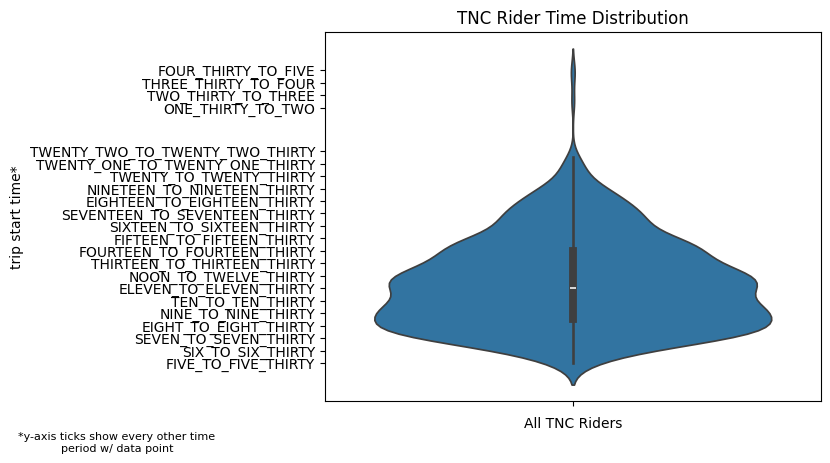

In [80]:
# is the tod distribution a result of underlying data or binning method?
    # it looks like samples for late EV and EA are too sparse to construct a category
sns.violinplot(survey_data.query('main_mode_label=="UBER_LYFT"')['trip_start_time'])

time_labels = survey_data[['trip_start_time','trip_start_time_label']].drop_duplicates().sort_values(by='trip_start_time')
plt.title('TNC Rider Time Distribution')
plt.yticks(ticks = time_labels.iloc[::2]['trip_start_time'],
           labels = time_labels.iloc[::2]['trip_start_time_label'])

plt.ylabel('trip start time*')
plt.xlabel('All TNC Riders')
caption="*y-axis ticks show every other time period w/ data point"
plt.figtext(-0.2, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=8)

plt.show()

### Fare Outlier EDA

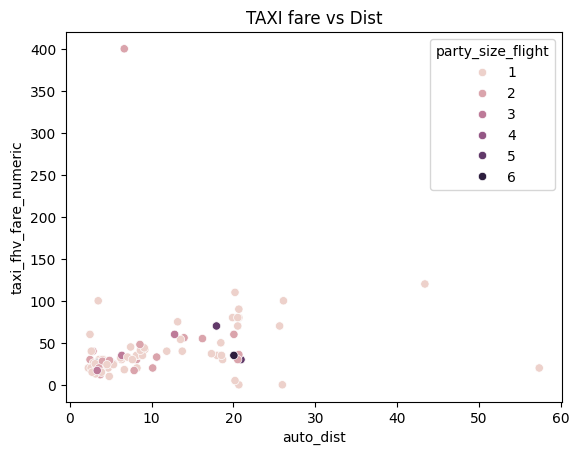

In [81]:
# scatterplot - cost vs distance for taxis
sns.scatterplot(
    data = (
            survey_data
            .query('main_mode_label=="TAXI"')
            # .query('taxi_fhv_fare_numeric < 1000')
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    hue = 'party_size_flight'
)
plt.title('TAXI fare vs Dist')
plt.show()

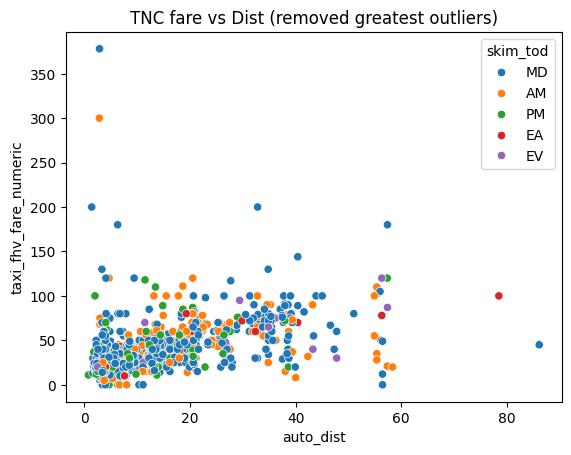

In [82]:
# scatterplot - cost vs distance colored by skim_tod
sns.scatterplot(
    data = (
            survey_data
            .query('main_mode_label=="UBER_LYFT"')
            .query('taxi_fhv_fare_numeric < 1000')
    ),
    x = 'auto_dist',
    y = 'taxi_fhv_fare_numeric',
    hue = 'skim_tod'
)
plt.title('TNC fare vs Dist (removed greatest outliers)')
plt.show()

### Cost per Mile EDA

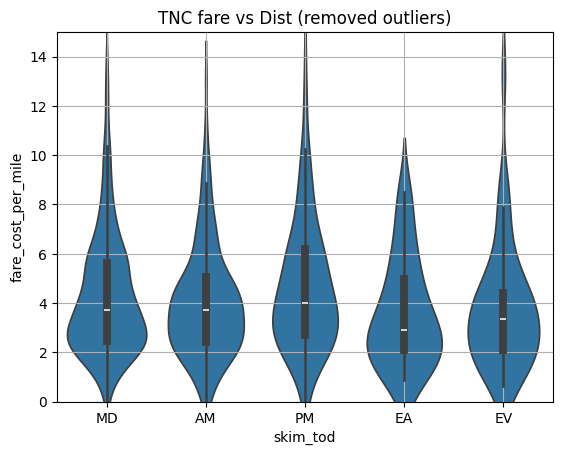

In [83]:
# violinplot - cost/mile by skim_tod
    # looks like there is greater skew and higher avg values for PM times
    # relatively the same

survey_data['fare_cost_per_mile'] = survey_data['taxi_fhv_fare_numeric'] / survey_data['auto_dist']
sns.violinplot(
    data = (
            survey_data
            .query('main_mode_label=="UBER_LYFT"')
            .query('taxi_fhv_fare_numeric < 150') # remove outliers to get better look at graph
            .query('fare_cost_per_mile < 15')
    ),
    x = 'skim_tod',
    y = 'fare_cost_per_mile',
)
plt.title('TNC fare vs Dist (removed outliers)')
plt.grid()
plt.ylim((0,15))
plt.show()

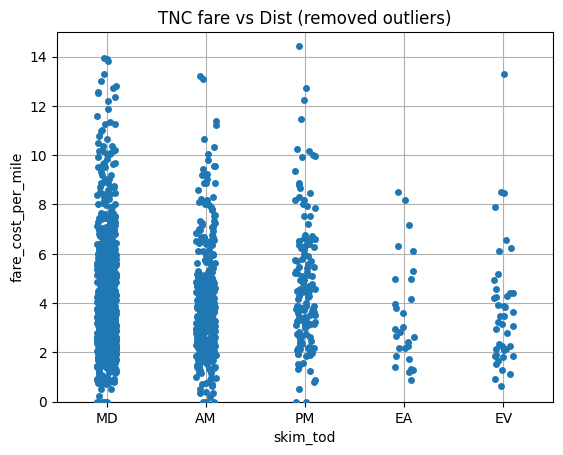

In [84]:
# jitterplot - cost/mile by skim_tod
    # alternative visual to above violinplot

survey_data['fare_cost_per_mile'] = survey_data['taxi_fhv_fare_numeric'] / survey_data['auto_dist']
sns.stripplot(
    data = (
            survey_data
            .query('main_mode_label=="UBER_LYFT"')
            .query('taxi_fhv_fare_numeric < 150') # remove outliers to get better look at graph
            # .query('fare_cost_per_mile < 15')
    ),
    x = 'skim_tod',
    y = 'fare_cost_per_mile',
)
plt.title('TNC fare vs Dist (removed outliers)')
plt.grid()
plt.ylim((0,15))
plt.show()

### Party Size EDA

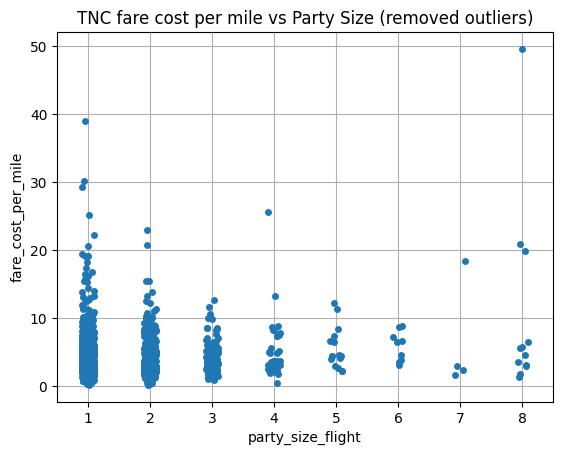

In [85]:
# jitterplot to analyze relationship between fare cost and part size
    # some logic in the model for large party sizes makes sense as vans would be more expensive but is not supported enough in the data
    # verdict: do not include party size in model

survey_data['fare_cost_per_mile'] = survey_data['taxi_fhv_fare_numeric'] / survey_data['auto_dist']
sns.stripplot(
    data = (
            survey_data
            .query('main_mode_label=="UBER_LYFT"')
            .query('taxi_fhv_fare_numeric > 0')
            .query('taxi_fhv_fare_numeric < 150') # remove outliers to get better look at graph
            # .query('fare_cost_per_mile < 15')
    ),
    x = 'party_size_flight',
    y = 'fare_cost_per_mile',
)
plt.title('TNC fare cost per mile vs Party Size (removed outliers)')
plt.grid()
plt.show()

### Granularity of Fares
survey should have used bins

In [86]:
fares = survey_data.query('taxi_fhv_fare_numeric.notna()')['taxi_fhv_fare_numeric']#.values
print(f'{(fares%1==0).sum()} out of {fares.shape[0]} fares reported whole number fare')
print(f'{(fares%5==0).sum()} out of {fares.shape[0]} fares reported fare divisible by 5.0 (should have a count of approximately {np.round(fares.shape[0]/5, 1)})')

1490 out of 1519 fares reported whole number fare
951 out of 1519 fares reported fare divisible by 5.0 (should have a count of approximately 303.8)


### Peak at Wait Times

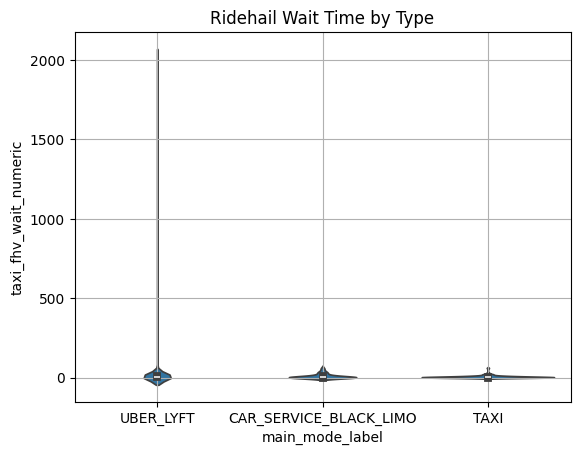

In [87]:
# violinplot - cost/mile by skim_tod
    # looks like there is greater skew and higher avg values for PM times
    # relatively the same

sns.violinplot(
    data = (
            survey_data
            # .query('main_mode_label=="UBER_LYFT"')
            .query('taxi_fhv_wait_numeric.notna()')
            # .query('fare_cost_per_mile < 15')
    ),
    x = 'main_mode_label',
    y = 'taxi_fhv_wait_numeric',
)
plt.title('Ridehail Wait Time by Type')
plt.grid()
# plt.ylim((0,15))
plt.show()

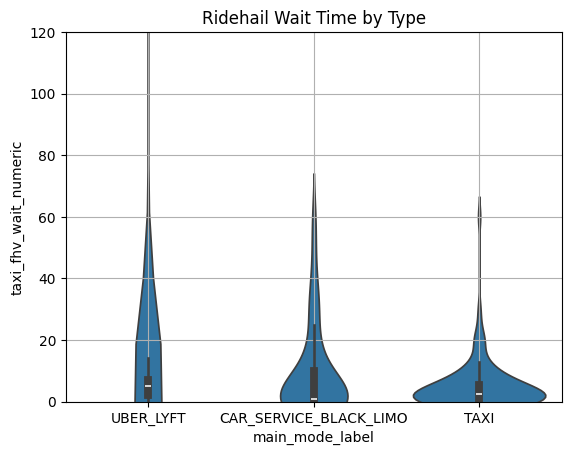

In [88]:
# violinplot - cost/mile by skim_tod
    # looks like there is greater skew and higher avg values for PM times
    # relatively the same

sns.violinplot(
    data = (
            survey_data
            # .query('main_mode_label=="UBER_LYFT"')
            .query('taxi_fhv_wait_numeric.notna()')
            # .query('fare_cost_per_mile < 15')
    ),
    x = 'main_mode_label',
    y = 'taxi_fhv_wait_numeric',
)
plt.title('Ridehail Wait Time by Type')
plt.grid()
plt.ylim((0,120))
plt.show()

## Organize Data

### Separate Taxi and TNC Fares

In [89]:
survey_data['ridehail_fare'] = survey_data['taxi_fhv_fare_numeric'].copy()

In [90]:
# remove 0 value fares
survey_data.loc[
        survey_data['ridehail_fare'] == 0,
        'ridehail_fare'
    ] = None

In [91]:
# remove outliers
    # TODO: improve process
outlier_list = pd.read_csv(taxi_tnc_fare_outliers_path)['unique_id'].tolist()
survey_data.loc[
        survey_data['unique_id'].isin(outlier_list),
        'ridehail_fare'
    ] = None

In [92]:
# split ridehail fare into tnc and taxi fare
fare_cols = ['tnc_fare','taxi_fare']
ridehail_modes = ['UBER_LYFT','TAXI']
for fare_col,mode in zip(fare_cols,ridehail_modes):
    survey_data.loc[
        survey_data['main_mode_label'] == mode,
        fare_col
    ] = (
        survey_data
        .loc[
            survey_data['main_mode_label'] == mode,
            'ridehail_fare'
        ]
    )

In [93]:
survey_data = survey_data.drop(columns = ['ridehail_fare'])

### TOD Alterations
mapping EA to AM and EV to PM - too few EA and EV TNC values

In [94]:
tod_map = {'EA':'AM', 'EV': 'PM'}
survey_data['skim_tod_simplified'] = survey_data['skim_tod'].replace(tod_map)

### Get Train/Test Indices for Taxi & TNC Models
for TNC, different models for each tod

In [95]:
# although taxi data is lacking, lack of model complexity still allows us to test model (only using auto_dist)
    # but bc we are not doing any feature engineering and only using one feature, value of testing negligible
survey_data['main_mode_label'].value_counts()[['UBER_LYFT','TAXI']]

main_mode_label
UBER_LYFT    1375
TAXI           99
Name: count, dtype: int64

In [96]:
taxi_train_index = survey_data.query("taxi_fare.notna()").index
X_train_taxi = survey_data.loc[taxi_train_index,'auto_dist'].values.reshape(-1,1)
y_train_taxi = survey_data.loc[taxi_train_index,'taxi_fare'].values

In [97]:
tnc_train_index = survey_data.query("tnc_fare.notna()").index
X_train_tnc = survey_data.loc[tnc_train_index,'auto_dist'].values.reshape(-1,1)
y_train_tnc = survey_data.loc[tnc_train_index,'tnc_fare'].values

In [98]:
survey_data.query('main_mode_label == "UBER_LYFT"')['skim_tod'].value_counts()

skim_tod
MD    800
AM    341
PM    162
EV     43
EA     29
Name: count, dtype: int64

In [99]:
survey_data.query('main_mode_label == "UBER_LYFT"')['skim_tod_simplified'].value_counts()

skim_tod_simplified
MD    800
AM    370
PM    205
Name: count, dtype: int64

In [100]:
features = ['auto_dist']#,'skim_tod_simplified']
tnc_data_dict = {}
# iterate thru all tods to create separate models
for tod in ['AM', 'MD', 'PM']:
    tnc_train_tod_index = (
        survey_data
        .query('tnc_fare.notna()')
        .query(f'skim_tod_simplified == "{tod}"')
        .index
    )
    X_tnc = survey_data.loc[tnc_train_tod_index, features].values.reshape(-1,len(features))
    y_tnc = survey_data.loc[tnc_train_tod_index,'tnc_fare'].values

    tnc_data_dict[tod] = {'X_tnc': X_tnc,'y_tnc': y_tnc}


## Train Fare Models

In [101]:
max_dist = 80

In [102]:
def model_flexibility_score(model, X, y):
    score = sklearn.model_selection.cross_val_score(model, X, y, cv=4)
    return score

In [103]:
def fare_model(X_train, y_train, title:str):
    model = sklearn.linear_model.LinearRegression()

    cv_score = model_flexibility_score(model, X_train, y_train)
    print(f'linear model mean R^2 cv score: {cv_score.mean().round(3)}')
    print(f'linear model std R^2 cv score: {cv_score.std().round(3)}')

    model.fit(X_train,y_train)

    print(f'fare_cost per file: {model.coef_}')
    print(f'base fare: {model.intercept_}')

    # plot model to data
    plt.scatter(x = X_train, y = y_train, label='survey', alpha=.5)
    plt.plot([0,max_dist],
            [model.intercept_, model.intercept_ + (max_dist * model.coef_[0])],
            'r--',
            label='model'
            )
    plt.title(title)
    plt.xlabel('miles')
    plt.ylabel('fare')
    plt.grid()
    plt.legend()

    return model

In [104]:
def plot_ci_intervals(model, X_train, y_train, style):

    y_pred = model.predict(X_train.reshape(-1, 1))

    # Calculate residuals and standard error
    residuals = y_train - y_pred.flatten()
    std_err = np.sqrt(np.sum(residuals**2) / (len(X_train) - 2))

    # Calculate confidence interval
    confidence_interval = 0.95
    t_value = scipy.stats.t.ppf((1 + confidence_interval) / 2, len(X_train) - 2)
    margin_error = t_value * std_err

    # Plotting
    plt.plot([0,max_dist],
            [model.intercept_ - margin_error, model.intercept_ + (max_dist * model.coef_[0]) - margin_error],
            style,
            alpha = .25)#, label='Lower Bound (95% CI)')
    plt.plot([0,max_dist],
            [model.intercept_ + margin_error, model.intercept_ + (max_dist * model.coef_[0]) + margin_error],
            style,
            alpha = .25)#, label='Upper Bound (95% CI)')
    plt.xlabel('auto dist')
    plt.ylabel('fare')
    plt.legend()

### Taxi Model
note that the variable nature of wait times (and time-based fees for sitting in traffic) makes the initial higher cost of the modeled taxi fares in comparison to the 2024 taxi fare calculator (https://www.taxi-calculator.com/taxi-fare-san-diego/267) reasonable. However, the lower mile-based fare is less than ideal, as sources say that the cost per mile for taxis is $3.30. Given that the modeled fare cost is $1 per mile less, this is concerning. 

on another note, it looks like maximum fares climbed quite a bit since 2025: https://www.sdmts.com/sites/default/files/2025-02/2024-02-26-public-hearing-notice-rates-of-fare.pdf

linear model mean R^2 cv score: 0.38
linear model std R^2 cv score: 0.345
fare_cost per file: [2.23429673]
base fare: 16.982297549804695


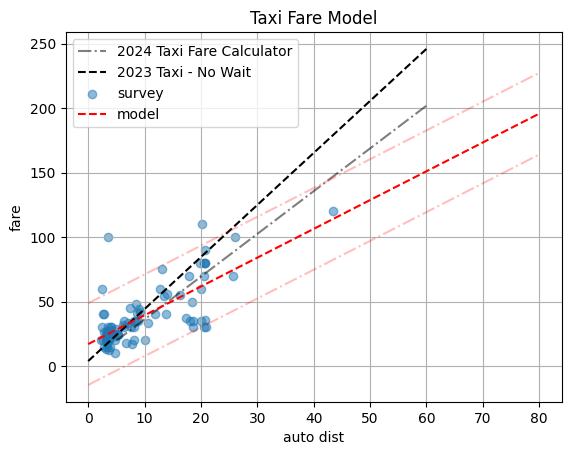

In [105]:
# 2023 data: https://www.sdmts.com/sites/default/files/2023-02-22-tac-agenda-and-materials_0.pdf p.18
plt.plot([5,60],
        [19.58, 201.91],
        'k-.',
        alpha=.5,
        label='2024 Taxi Fare Calculator'
        )
plt.plot([0,60],
        [3.80, 60 * 4.10],
        'k--',
        label='2023 Taxi - No Wait'
                )
taxi_model = fare_model(X_train_taxi,y_train_taxi, 'Taxi Fare Model')
plot_ci_intervals(taxi_model, X_train_taxi, y_train_taxi, 'r-.')
plt.show()

### TNC Model

linear model mean R^2 cv score: 0.42
linear model std R^2 cv score: 0.074
fare_cost per file: [1.31052266]
base fare: 19.989939671360023


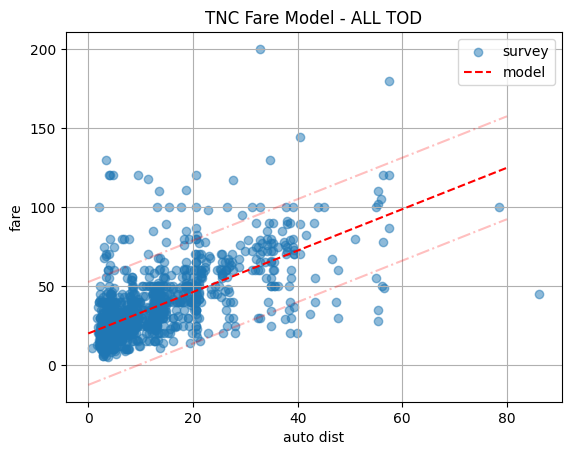

In [106]:
tnc_all_tod_model = fare_model(X_train_tnc,y_train_tnc, 'TNC Fare Model - ALL TOD')
plot_ci_intervals(tnc_all_tod_model, X_train_tnc, y_train_tnc, 'r-.')

linear model mean R^2 cv score: 0.381
linear model std R^2 cv score: 0.057
fare_cost per file: [1.21384403]
base fare: 21.87681121772387


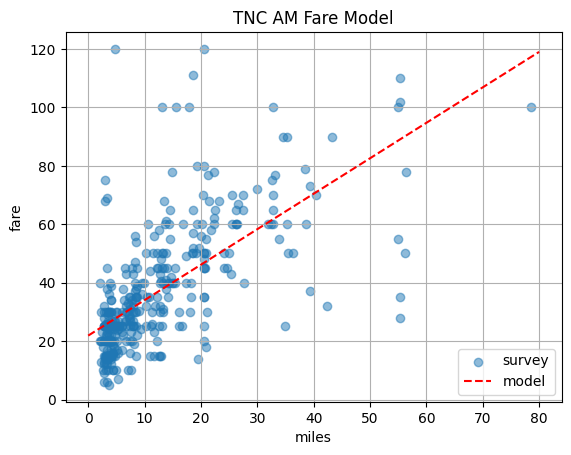

In [107]:
tod='AM'
tnc_am_model = fare_model(tnc_data_dict[tod]['X_tnc'], tnc_data_dict[tod]['y_tnc'], f'TNC {tod} Fare Model')

linear model mean R^2 cv score: 0.415
linear model std R^2 cv score: 0.087
fare_cost per file: [1.36082056]
base fare: 18.88048486969842


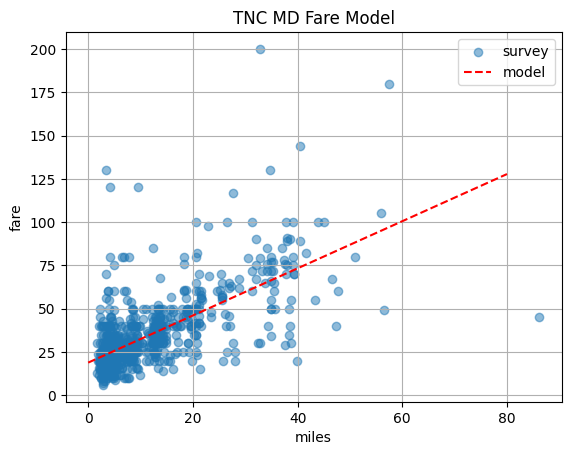

In [108]:
tod='MD'
tnc_md_model = fare_model(tnc_data_dict[tod]['X_tnc'], tnc_data_dict[tod]['y_tnc'], f'TNC {tod} Fare Model')

linear model mean R^2 cv score: 0.284
linear model std R^2 cv score: 0.296
fare_cost per file: [1.3117524]
base fare: 20.974801536230856


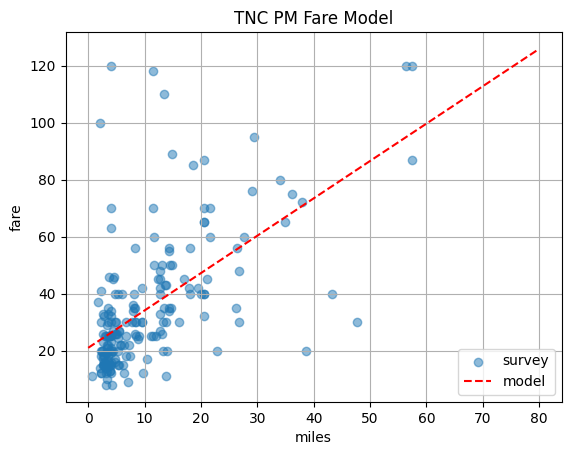

In [109]:
tod='PM'
tnc_pm_model = fare_model(tnc_data_dict[tod]['X_tnc'], tnc_data_dict[tod]['y_tnc'], f'TNC {tod} Fare Model')

24hr_model - 5mi fare: 26.5, 10mi fare: 33.1, 50mi fare: 85.5


am_model - 5mi fare: 27.9, 10mi fare: 34.0, 50mi fare: 82.6
md_model - 5mi fare: 25.7, 10mi fare: 32.5, 50mi fare: 86.9
pm_model - 5mi fare: 27.5, 10mi fare: 34.1, 50mi fare: 86.6


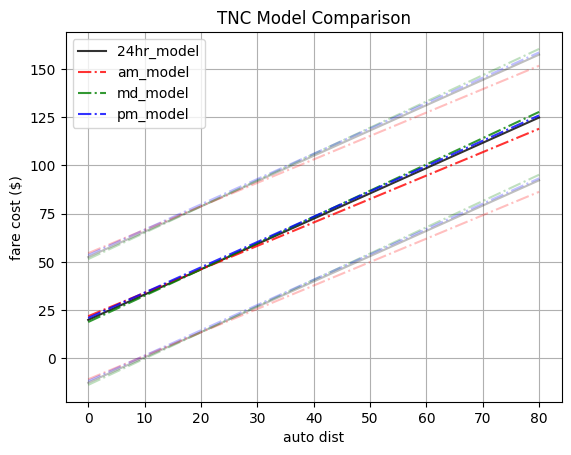

In [110]:
# compare models
max_dist = 80
tnc_models = {'24hr_model': [tnc_all_tod_model, 'k-'], 'am_model': [tnc_am_model, 'r-.'], 'md_model': [tnc_md_model, 'g-.'], 'pm_model': [tnc_pm_model, 'b-.']}

for model_name, values in tnc_models.items():
    model = values[0]
    style = values[1]
    fare_calc = (lambda dist : np.round(model.intercept_ + (dist * model.coef_[0]), 1))  # noqa: E731
    plt.plot([0,max_dist],
            [model.intercept_, fare_calc(max_dist)],
            style,
            label=model_name,
            alpha = .8
            )
    plot_ci_intervals(model, X_train_tnc, y_train_tnc, style)
    print(f'{model_name} - 5mi fare: {fare_calc(5)}, 10mi fare: {fare_calc(10)}, 50mi fare: {fare_calc(50)}')
plt.title('TNC Model Comparison')
plt.ylabel('fare cost ($)')
plt.xlabel('auto dist')
plt.legend()
plt.grid()
plt.show()

### Test TNC Model

In [111]:
# def test_tnc_model(model, X_test, y_test, title:str):
#     score = model.score(X_test, y_test)
#     print(f'mode R^2: {score}')

#     plt.scatter(x = X_test, y = y_test, label='survey', alpha=.5)
#     max_dist = 60
#     plt.plot([0,max_dist],
#             [model.intercept_, model.intercept_ + (max_dist * model.coef_[0])],
#             'r--',
#             label='model'
#             )
#     plt.title(title)
#     plt.xlabel('miles')
#     plt.ylabel('fare')
#     plt.grid()
#     plt.legend()
#     plt.show()

#     return score

In [112]:
# tod = 'AM'
# test_tnc_model(tnc_am_model, tnc_data_dict[tod]['X_test_tnc'], tnc_data_dict[tod]['y_test_tnc'], f'TNC {tod} Model')

## Model Fares for Unchosen Alternatives

In [113]:
def plot_fare_columns(fare_col: str, models: dict, mode: str):
    # plot model to data
    plt.scatter(data = survey_data.query(f'main_mode_label=="{mode}"'), x = 'auto_dist', y = f'{fare_col}_mixed', label='survey', alpha=.5, color='r')
    plt.scatter(data = survey_data.query(f'main_mode_label!="{mode}"'), x = 'auto_dist', y = f'{fare_col}_mixed', label='unchosen alt', alpha=.025, color = 'blue')
    max_dist = 100
    for model_name, values in models.items():
        model = values[0]
        style = values[1]
        plt.plot([0,max_dist],
                [model.intercept_, model.intercept_ + (max_dist * model.coef_[0])],
                style,
                label=model_name,
                alpha = .8
                )
    plt.title(f'{mode} Model vs Survey Fare Comparison')
    plt.xlabel('miles')
    plt.ylabel('fare')
    plt.grid()
    plt.legend()
    plt.show()

In [114]:
# model taxi fares
modeled_taxi_fare = taxi_model.predict(survey_data['auto_dist'].values.reshape(-1,1))
survey_data['modeled_taxi_fare'] = modeled_taxi_fare

# coalesce predicted taxi fare onto existing taxi_fare column
survey_data['taxi_fare_mixed'] = survey_data['taxi_fare'].combine_first(survey_data['modeled_taxi_fare'])

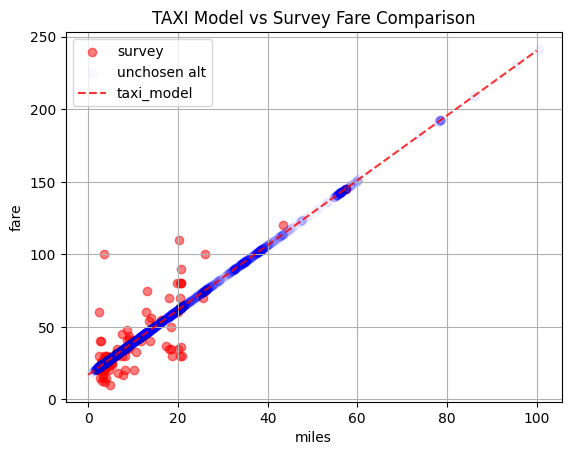

In [115]:
plot_fare_columns('taxi_fare', {'taxi_model': [taxi_model, 'r--']}, 'TAXI')

In [116]:
# # model tnc fares by TOD
# tods = ['AM', 'MD', 'PM']
# models = [tnc_am_model,tnc_md_model,tnc_pm_model]

# for tod, model in zip(tods, models):
#     tod_index = survey_data.query(f'skim_tod_simplified == "{tod}"').index

#     # model tnc tod fares
#     X = survey_data.loc[tod_index, 'auto_dist'].values.reshape(-1,1)
#     modeled_tnc_fare = model.predict(X)
#     survey_data.loc[tod_index, 'modeled_tnc_fare'] = modeled_tnc_fare

#     # coalesce predicted tnc fare onto existing tnc_fare column
#     survey_data.loc[tod_index, 'tnc_fare_mixed'] = survey_data.loc[tod_index, 'tnc_fare'].combine_first(survey_data.loc[tod_index, 'modeled_tnc_fare'])
#     # survey_data = survey_data.drop(columns=['modeled_tnc_fare'])

# plot_fare_columns('tnc_fare', {'am_model': [tnc_am_model, 'r--'], 'md_model': [tnc_md_model, 'g--'], 'pm_model': [tnc_pm_model, 'k--']}, 'UBER_LYFT')

In [117]:
# model tnc fares
modeled_tnc_fare = tnc_all_tod_model.predict(survey_data['auto_dist'].values.reshape(-1,1))
survey_data['modeled_tnc_fare'] = modeled_tnc_fare

# coalesce predicted tnc fare onto existing tnc_fare column
survey_data['tnc_fare_mixed'] = survey_data['tnc_fare'].combine_first(survey_data['modeled_tnc_fare'])

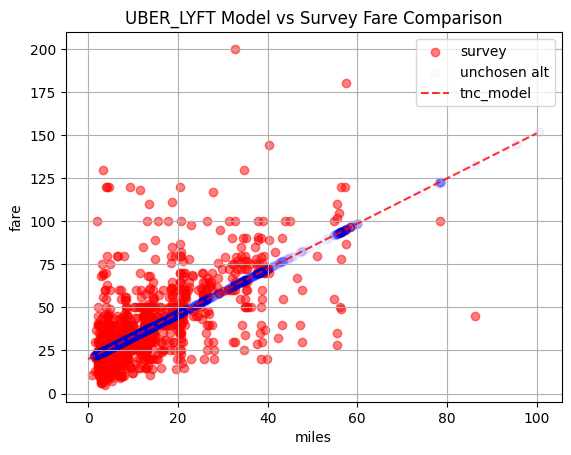

In [118]:
plot_fare_columns('tnc_fare', {'tnc_model': [tnc_all_tod_model, 'r--']}, 'UBER_LYFT')

## Write Out Fare Estimates

In [119]:
modeled_dare_data = pd.DataFrame(
    data= [
        [taxi_model.coef_[0], taxi_model.intercept_],
        [tnc_all_tod_model.coef_[0], tnc_all_tod_model.intercept_]
    ],
    index= ['taxi_model','tnc_model'],
    columns= ['fare_cost_per_mile','base_fare']
)
modeled_dare_data

,fare_cost_per_mile,base_fare
taxi_model,2.234297,16.982298
tnc_model,1.310523,19.989940


In [120]:
modeled_dare_data.to_csv(output_path, index=True)